Actor-Critic 算法本质上是基于策略的算法，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数，从而帮助策略函数更好地学习。

回顾一下，在 REINFORCE 算法中，目标函数的梯度中有一项轨迹回报，用于指导策略的更新。REINFOCE 算法用蒙特卡洛方法来估计$Q(s,a)$,能不能考虑拟合一个值函数来指导策略进行学习呢？这正是 Actor-Critic 算法所做的。在策略梯度中，可以把梯度写成下面这个更加一般的形式：

$$g=\mathbb{E}\left[\sum_{t=0}^T\psi_t\nabla_\theta\log\pi_\theta(a_t|s_t)\right]$$

其中，$\psi_t$可以有很多种形式：

$$\begin{aligned}&1.\sum_{t^{\prime}=0}^T\gamma^{t^{\prime}}r_{t^{\prime}}:\textit{轨迹的总回振;}\\&2.\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^{\prime}}:\textit{动作}a_t\textit{之后的回报;}\\&3.\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^{\prime}}-b(s_t):\textit{基准线版本的改进;}\\&4.\:Q^{\pi_0}(s_t,a_t):\textit{动作价值因数;}\\&5.\:A^{\pi_0}(s_t,a_t):\textit{优势图数;}\\&6.\:r_t+\gamma V^{\pi_0}(s_{t+1})-V^{\pi_0}(s_t):\textit{时序差分残差。}\end{aligned}$$

9.5 节提到 REINFORCE 通过蒙特卡洛采样的方法对策略梯度的估计是无偏的，但是方差非常大。我们可以用形式(3)引入基线函数 (baseline function) $b(s_t)$来减小方差。

此外，我们也可以采用 Actor-Critic 算法估计一个动作价值函数$Q$,代替蒙特卡洛采样得到的回报，这便是形式(4)。

这个时候，我们可以把状态价值函数$V$作为基线，从$Q$函数减去这个$V$函数则得到了$A$函数， 我们称之为优势函数(advantage function),这便是形式(5)。

更进一步，我们可以利用$G = r+\gamma V$等式得到形式(6)。

本章将着重介绍形式(6),即通过时序差分残差 $\psi_t=r_t+\gamma V^\pi(s_{t+1})-V^\pi(s_t)$ 来指导策略梯度进行学习。

事实上，用 $Q$ 值或者$V$值本质上也是用奖励来进行指导，但是用神经网络进行估计的方法可以减小方差、提高鲁棒性。

除此之外，REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这同时也要求任务具有有限的步数，而Actor-Critic 算法则可以在每一步之后都进行更新，并且不对任务的步数做限制。

我们将 Actor-Critic 分为两个部分：Actor(策略网络)和 Critic(价值网络)

·Actor 要做的是与环境交互，并在 Critic 价值函数的指导下用策略梯度学习一个更好的策略。

·Critic 要做的是通过 Actor 与环境交互收集的数据学习一个价值函数，这个价值函数会用于判断在当前状态什么动作是好的，什么动作不是好的，进而帮助 Actor 进行策略更新。

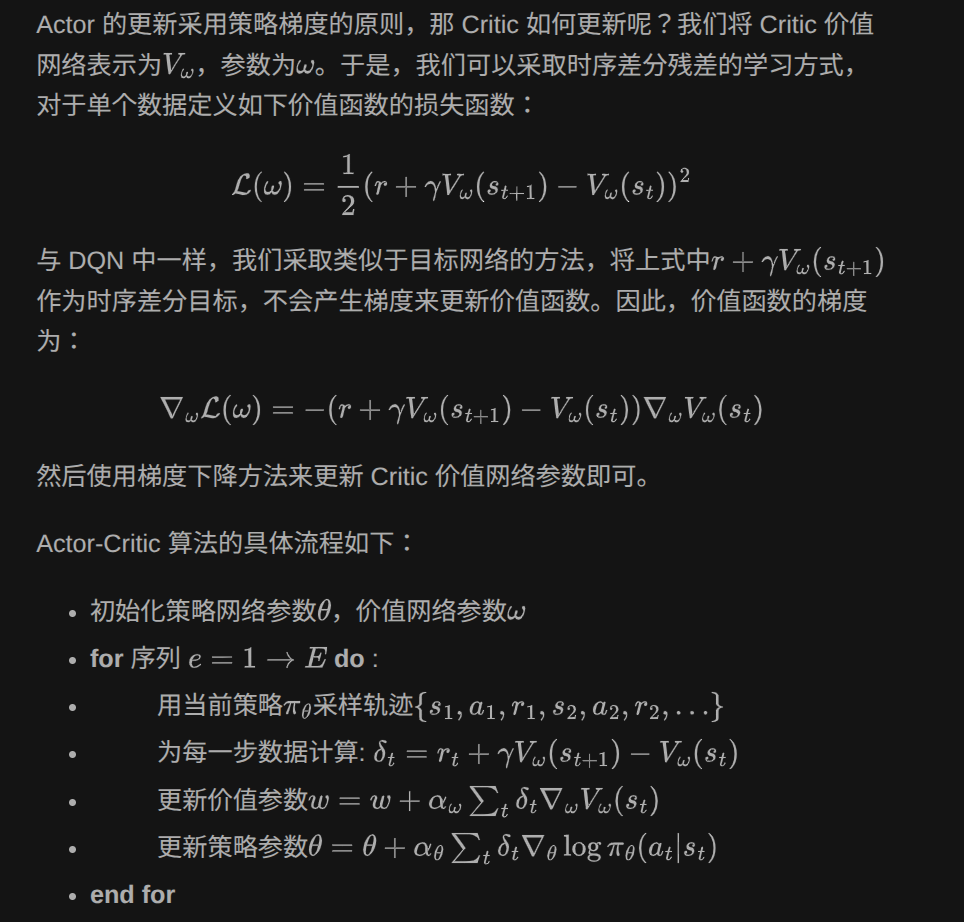

In [53]:
"""这一部分和REINFORCE中完全一致"""
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [54]:
"""AC不同的地方"""
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)           # action_dim = 1

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [55]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device\
        
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_list = torch.distributions.Categorical(probs)
        action = action_list.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        # 时序差分的目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)

        #时序差分的误差
        td_delta = td_target - self.critic(states)

        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())     # detach()切断梯度传播，两网络共享信息，不共享梯度
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [56]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
print(device)



env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset(seed = 0)[0]
            done = False
            # 此处的steps就是Return的最大值，也就是维持的时间长短
            steps = 0
            while not done and steps < 200:
                steps += 1
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

cuda


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s, episode=1000, return=199.700]


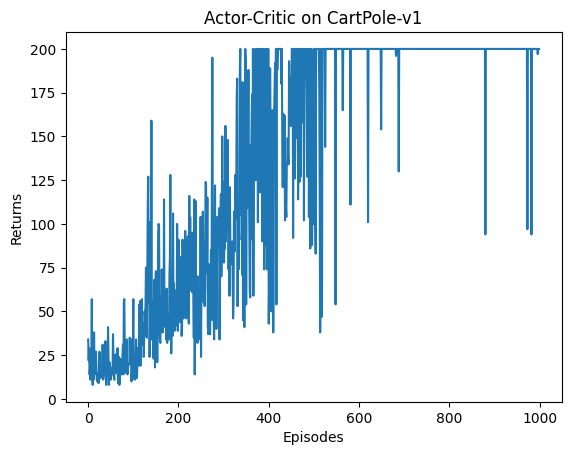

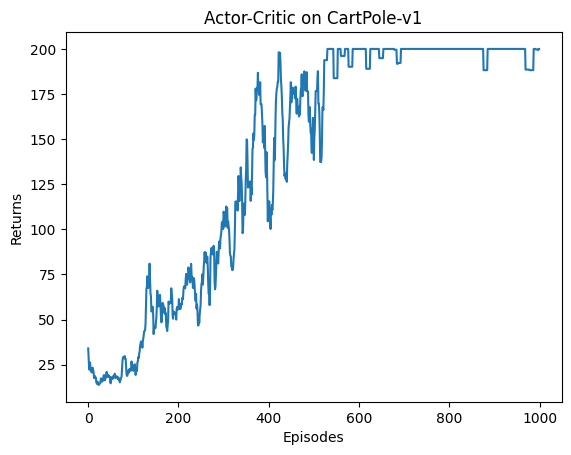

In [57]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

注意到，AC算法能非常迅速地收敛到最佳策略，且相比REINFORCE算法显著减小了抖动，说明价值函数的引入减小了方差。